In [19]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import copy

In [2]:
# Tree data
tree_df = pd.DataFrame(data = {"Daughter_1": [2, 1, 4, 11, 10, 7, 13],
                               "Branch_Length_1": [2.7, 1.8, 1.1, 1.9, 1.5, 4.7, 2.2],
                               "Daughter_2": [3, 9, 5, 6, 12, 8, 14],
                               "Branch_Length_2": [2.7, 4.5, 1.1, 3, 3, 4.7, 3.5]},
                       index = [9, 10, 11, 12, 13, 14, 15])

display(tree_df)

,Daughter_1,Branch_Length_1,Daughter_2,Branch_Length_2
9,2,2.7,3,2.7
10,1,1.8,9,4.5
11,4,1.1,5,1.1
12,11,1.9,6,3.0
13,10,1.5,12,3.0
14,7,4.7,8,4.7
15,13,2.2,14,3.5


In [3]:
class TreeInference():
    """
    tree_data: dataframe of nodes, daughters and branch length for an evolutionary tree
    leaf_values: bases for leaf nodes
    pi: prior probability that a state is at the root of the tree
    mu: mutation rate
    """
    def __init__(self, tree_data, leaf_values, pi, mu = 0.01):
        # Set parameters
        self.tree_data = tree_data.copy()
        self.leaf_values = leaf_values
        self.pi = np.array(pi)
        self.mu = mu
        
        # Find IDs of internal nodes, all nodes and leaf nodes
        self.internal_node_ids = np.array(tree_data.index)
        self.all_node_ids = np.unique(np.concatenate((np.array(self.tree_data.index),
                                                      np.array(self.tree_data["Daughter_1"]),
                                                      np.array(self.tree_data["Daughter_2"]))))
        self.leaf_node_ids = list(set(self.all_node_ids) - set(self.internal_node_ids))
        
        # Record branch lengths from root to leaves
        self.root_node = -1
        self.root_leaf_dist = {}
        
        # Count internal nodes and leaves for each row in tree_data and set root node
        self.treeNodeCounts()
        
        # Get indexes for Q and A matricies for states, e.g. A is row 0, C is row 2...
        states = np.unique(list(leaf_values.values()))
        self.matrix_idx = dict(zip(states, range(len(states))))
        
        # Empty Q matrix for bases A, C, T, G
        self.Q = np.full((len(self.matrix_idx), len(self.matrix_idx)), None)
        # Empty matrix of likelihood for each node
        self.L = np.full((len(self.all_node_ids), len(self.matrix_idx)), None)
        # Log likelihood of whole tree
        L_root = None
        
    # For each internal node, calculate the number of internal nodes and leaves below
    def treeNodeCounts(self):
        n_nodes = np.array([])
        n_leaves = np.array([])
        max_leaves = 0

        # Set the number of internal nodes and leaves for each internal node row
        for n in self.internal_node_ids:
            num_nodes, num_leaves, leaf_dist = self.checkNode(self.tree_data,
                                                              n,
                                                              self.internal_node_ids)
            n_nodes = np.append(n_nodes, num_nodes)
            n_leaves = np.append(n_leaves, num_leaves)

            # Check if found root node
            if len(leaf_dist) > max_leaves:
                # Set the root node
                self.root_node = n
                # Record branch lengths to leaves
                self.root_leaf_dist = leaf_dist
                max_leaves = len(leaf_dist)

        # Add new information to dataframe
        self.tree_data["N_Internal"] = n_nodes
        self.tree_data["N_Leaves"] = n_leaves
                
    # Recursively find the number of internal nodes and leaves given a node ID
    def checkNode(self, tree_data, node_id, node_array):
        # Record the number of internal nodes and leaves below
        num_nodes = 0
        num_leaves = 0
        # Record branch lengths of leaves below
        leaf_lengths = {}

        # Find the left and right daughter nodes
        daughter_1 = self.tree_data.loc[node_id]["Daughter_1"]
        daughter_2 = self.tree_data.loc[node_id]["Daughter_2"]

        # Check if found an internal node to the left
        if daughter_1 in node_array:
            # Recursively check nodes below
            d1_nodes, d1_leaves, d1_leaf_lengths = self.checkNode(self.tree_data,
                                                                  daughter_1, node_array)
            num_nodes += d1_nodes + 1
            num_leaves += d1_leaves

            # Increment branch lengths of leaves
            for l in d1_leaf_lengths.keys():
                leaf_lengths[l] = round(d1_leaf_lengths[l] + tree_data.loc[node_id]["Branch_Length_1"], 1)

        # Otherwise found a left leaf node
        else:
            num_leaves += 1
            leaf_lengths[daughter_1] = self.tree_data.loc[node_id]["Branch_Length_1"]

        # Check if found an internal node to the right
        if daughter_2 in node_array:
            d2_nodes, d2_leaves, d2_leaf_lengths = self.checkNode(self.tree_data,
                                                                  daughter_2,
                                                                  node_array)
            num_nodes += d2_nodes + 1
            num_leaves += d2_leaves

            for l in d2_leaf_lengths.keys():
                leaf_lengths[l] = round(d2_leaf_lengths[l] + self.tree_data.loc[node_id]["Branch_Length_2"], 1)

        # Otherwise found a right leaf node
        else:
            num_leaves += 1
            leaf_lengths[daughter_2] = self.tree_data.loc[node_id]["Branch_Length_2"]

        return num_nodes, num_leaves, leaf_lengths
    
    # Jukes-Cantor model Q matrix
    def setMatrixQ(self, mu):
        # Create matrix with all off-diagonal rates in Q as the same value
        self.Q = np.full((len(self.matrix_idx), 
                          len(self.matrix_idx)),
                         mu/(len(self.matrix_idx) - 1))
        np.fill_diagonal(self.Q, 1 - mu)
    
    # Create transition matrix for time t
    def transitionMatrixA(self, t, mu):
        A = np.full((4, 4), (1/4) * (1 - math.exp(-4 * mu * t)))
        np.fill_diagonal(A, (1/4) * (1 + 3 * math.exp(-4 * mu * t)))
        return A
    
    # Calculate likelihood for an internal node
    def nodeLikelihood(self, node_n, mu):
        # Find the left and right daughter nodes
        daughter_1 = self.tree_data.loc[node_n]["Daughter_1"]
        daughter_2 = self.tree_data.loc[node_n]["Daughter_2"]
        
        # Check if likelihood of left child node set
        if (self.L[int(daughter_1) - 1, 0] is None):
            # If not set then calculate child likelihood first
            self.nodeLikelihood(int(daughter_1), mu)
        # Check if likelihood of right child node set
        if (self.L[int(daughter_2) - 1, 0] is None):
            self.nodeLikelihood(int(daughter_2), mu)
        
        # Get branch length times for child nodes
        t1 = self.tree_data.loc[node_n]["Branch_Length_1"]
        t2 = self.tree_data.loc[node_n]["Branch_Length_2"]
        
        # Create transition matrix for left and right child for t1 and t2
        A1 = self.transitionMatrixA(t1, mu)
        A2 = self.transitionMatrixA(t2, mu)
        
        # Get conditional likelihood of child nodes
        d1_likelihood = self.L[int(daughter_1) - 1]
        d2_likelihood = self.L[int(daughter_2) - 1]
        
        # Calculate the likelihood of each state for the node
        left_prob = np.sum(A1 * d1_likelihood, axis = 1)
        right_prob = np.sum(A2 * d2_likelihood, axis = 1)
        self.L[node_n - 1] = np.multiply(left_prob, right_prob)
    
    # Run Felsenstein’s algorithm to calculate the log likelihood of the tree
    def calculateLikelihood(self, mu):
        # Fill Q matrix for bases A, C, T, G
        self.Q = self.setMatrixQ(mu)
        # Clear matrix of likelihood for each node
        self.L = np.full((len(self.all_node_ids), len(self.matrix_idx)), None)
        
        # Set likelihood of leaf states
        for leaf_n in self.leaf_node_ids:
            # Zero for non-matching base
            self.L[leaf_n - 1] = 0
            # One for matching base
            self.L[leaf_n - 1, self.matrix_idx[self.leaf_values[leaf_n]]] = 1
        
        for node_n in self.internal_node_ids:
            # Check likelihood has not been set
            if self.L[node_n - 1, 0] is None:
                # Calculate conditional likelihood of each state for the node
                self.nodeLikelihood(node_n, mu)
                
        # Calculate likelihood of the whole tree
        self.L_root = math.log(sum(np.multiply(self.pi, self.L[self.root_node - 1])))
        
        return self.L_root

In [20]:
tree_leaves = {1: "A", 2: "G", 3: "T", 4: "G", 5: "G", 6: "G", 7: "C", 8: "G"}

# Create tree from data
tree_inference = TreeInference(tree_df, mu = 0.01,
                               pi = [1/4, 1/4, 1/4, 1/4],
                               leaf_values = tree_leaves)
# View the updated data frame
display(tree_inference.tree_data)

# Print the distances from the root to each leaf
print("Leaf distance from root node " + str(tree_inference.root_node) + ":")
print(tree_inference.root_leaf_dist)

# Calculate likelihood for a given mu
tree_inference.calculateLikelihood(tree_inference.mu)
print("\nQ matrix: \n" + str(tree_inference.Q))
print("\nL matrix: \n" + str(tree_inference.L))
print("\nLog likelihood of evolutionary tree: \n" + str(tree_inference.L_root))

,Daughter_1,Branch_Length_1,Daughter_2,Branch_Length_2,N_Internal,N_Leaves
9,2,2.7,3,2.7,0.0,2.0
10,1,1.8,9,4.5,1.0,3.0
11,4,1.1,5,1.1,0.0,2.0
12,11,1.9,6,3.0,1.0,3.0
13,10,1.5,12,3.0,4.0,6.0
14,7,4.7,8,4.7,0.0,2.0
15,13,2.2,14,3.5,6.0,8.0


Leaf distance from root node 15:
{1.0: 5.5, 2.0: 10.9, 3.0: 10.9, 4.0: 8.2, 5.0: 8.2, 6.0: 8.2, 7.0: 8.2, 8.0: 8.2}

Q matrix: 
None

L matrix: 
[[1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 1 0]
 [0.0006550068132881193 0.0006550068132881193 0.02362808045252692
  0.02362808045252692]
 [0.002414468777482083 4.4237605906193515e-05 0.00037749347391742853
  0.00037749347391742853]
 [0.00011581011107701711 0.00011581011107701711 0.9364732272092632
  0.00011581011107701711]
 [0.0004875809010589545 0.0004875809010589545 0.8100153613472278
  0.0004875809010589546]
 [5.4240159633912015e-05 2.067307870154045e-06 0.000298247250522619
  9.40284088046066e-06]
 [0.0018358074110587364 0.037338900958653644 0.037338900958653644
  0.0018358074110587364]
 [2.382249046524016e-07 3.347202342100392e-07 9.833142778092193e-06
  6.762358759681414e-08]]

Log likelihood of evolutionary tree: 
-12.852936467567309


In [21]:
def optimiseMu(tree):
    # Generate mu values in range 0, 0.01, ..., 0.99, 1
    mu_values = np.array([i/1000 for i in range(1, 1001)])
    # Create placeholder for likelihood values
    mu_likelihoods = np.full(len(mu_values), None)

    # Record likelihood for each mu
    for i in range(len(mu_values)):
        mutation_rate = mu_values[i]
        likelihood = tree.calculateLikelihood(mu = mutation_rate)
        mu_likelihoods[i] = likelihood
        
    best_mu = mu_values[np.argmax(mu_likelihoods)]
    highest_likelihood = max(mu_likelihoods)
        
    return(mu_likelihoods, mu_values, best_mu, highest_likelihood)

likelihoods, mu_vals, optimal_mu, mu_likelihood = optimiseMu(tree_inference)

print("Best mutation rate (\u03bc) is: " + str(optimal_mu))
print("Highest likelihood is: " + str(mu_likelihood))

Best mutation rate (μ) is: 0.076
Highest likelihood is: -10.127651440360225


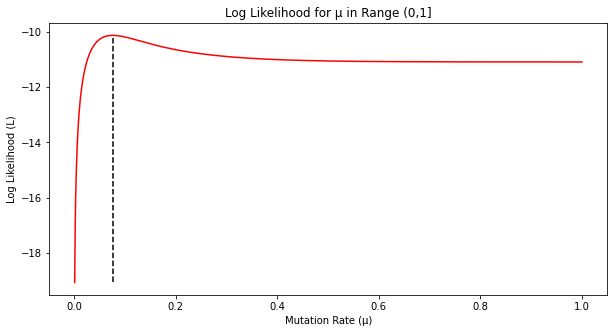

In [22]:
def plotLikelihood(mu_likelihoods, mu_values, best_mu):
    # Plot log likelihood over mutation rate
    fig = plt.figure(figsize = (10, 5))
    plt.plot(mu_values, mu_likelihoods, color = "red")
    plt.vlines(x = best_mu,
               ymin = min(mu_likelihoods),
               ymax = max(mu_likelihoods),
               colors = 'black',
               ls = '--')
    plt.xlabel("Mutation Rate (\u03bc)") 
    plt.ylabel("Log Likelihood (L)") 
    plt.title("Log Likelihood for \u03bc in Range (0,1]")
    plt.show()
    
    return fig

likelihood_plot = plotLikelihood(likelihoods, mu_vals, optimal_mu)
likelihood_plot.savefig("Original_Tree_Likelihood.pdf", bbox_inches = "tight")

Best mutation rate (μ) is: 1.0
Highest likelihood is: -11.090505633886318


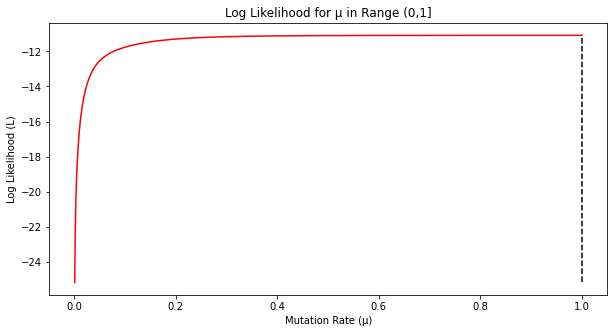

In [37]:
new_tree_leaves = {1: "C", 2: "T", 3: "C", 4: "C", 5: "G", 6: "A", 7: "T", 8: "T"}

# Copy original tree and reassign leaf values
new_tree_inference = copy.deepcopy(tree_inference)
new_tree_inference.leaf_values = new_tree_leaves

# Find best mutation rate
likelihoods, mu_vals, optimal_mu, mu_likelihood = optimiseMu(new_tree_inference)

print("Best mutation rate (\u03bc) is: " + str(optimal_mu))
print("Highest likelihood is: " + str(mu_likelihood))

# Plot log likelihood over mutation rate
likelihood_plot = plotLikelihood(likelihoods, mu_vals, optimal_mu)
likelihood_plot.savefig("New_Tree_Likelihood.pdf", bbox_inches = "tight")

In [68]:
# Number of new leaf assignments to test
n_random_assignments = 1000
# Create placeholder for best mu
random_best_mu = np.full(n_random_assignments, None)
random_leaves = np.full(n_random_assignments, None)

for i in range(n_random_assignments):
    # Randomly generate new leaf bases
    random_leaf_values = random.choices(["A", "C", "G", "T"], k = len(tree_leaves))
    random_tree_leaves = dict(zip(list(range(1, len(random_leaf_values) + 1)),
                                  random_leaf_values))

    # Copy original tree and reassign leaf values
    random_tree_inference = copy.deepcopy(tree_inference)
    random_tree_inference.leaf_values = random_tree_leaves

    # Find best mutation rate
    likelihoods, mu_vals, optimal_mu, mu_likelihood = optimiseMu(random_tree_inference)

    # Record best mu and leaf assignments
    random_best_mu[i] = optimal_mu
    random_leaves[i] = random_tree_leaves

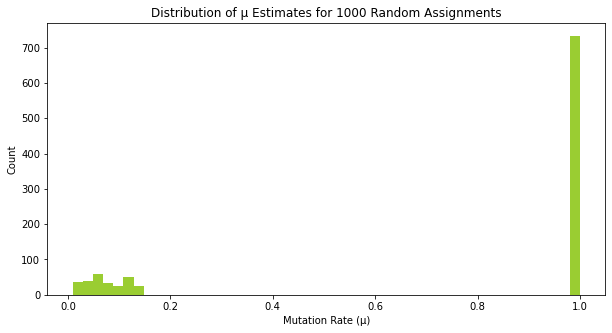

In [77]:
def plotMuHistogram(best_mu_values, n_assignments = 1000):
    # Plot distribution of best mu values
    fig = plt.figure(figsize = (10, 5))
    plt.hist(random_best_mu, bins = 50, color = "yellowgreen")
    plt.xlabel("Mutation Rate (\u03bc)") 
    plt.ylabel("Count") 
    plt.title("Distribution of \u03bc Estimates for " + str(n_assignments) + " Random Assignments")
    plt.show()
    
    return fig

# Plot distribution of mu values
mu_hist = plotMuHistogram(random_best_mu, n_random_assignments)
mu_hist.savefig("Mu_Histogram.pdf", bbox_inches = "tight")

In [96]:
assigned_leaves = np.copy(random_leaves)

for i in range(len(assigned_leaves)):
    # Add x to each node ID
    assigned_leaves[i] = {"x" + str(k): v for k, v in assigned_leaves[i].items()}

# Visualise leaf assignments and their best mutation rates in a dataframe
leaf_assignment_df = pd.DataFrame(list(assigned_leaves))
leaf_assignment_df["Mu"] = random_best_mu

display(leaf_assignment_df)

print("Number mutation rates as 1: " + str(sum(leaf_assignment_df["Mu"] == 1)))
print("Lowest mutation rate: " + str(min(leaf_assignment_df["Mu"])))

,x1,x2,x3,x4,x5,x6,x7,x8,Mu
0,G,C,G,C,C,C,A,G,0.06
1,C,G,A,T,C,T,A,C,1.0
2,T,T,C,A,G,A,G,T,1.0
3,C,C,T,A,A,T,A,C,0.117
4,A,A,A,G,A,C,A,A,0.023
...,...,...,...,...,...,...,...,...,...
995,G,G,C,T,G,G,A,A,1.0
996,A,G,G,G,A,T,C,A,1.0
997,C,G,A,C,T,G,C,G,1.0
998,C,C,G,G,A,C,T,T,1.0


Number mutation rates as 1: 733
Lowest mutation rate: 0.009


In [97]:
# Display leaf assignments with lowest and highest mu
leaf_assignment_df.sort_values(by = ["Mu"])

,x1,x2,x3,x4,x5,x6,x7,x8,Mu
518,C,C,C,T,C,C,C,C,0.009
695,A,A,A,A,T,A,A,A,0.009
596,T,T,T,T,G,T,T,T,0.009
325,C,A,A,A,A,A,A,A,0.01
857,C,T,C,C,C,C,C,C,0.01
...,...,...,...,...,...,...,...,...,...
388,C,G,C,C,G,G,A,G,1.0
389,T,T,C,A,G,T,C,G,1.0
390,G,T,G,C,A,C,C,C,1.0
351,G,T,C,C,G,T,C,G,1.0
